# Causal modelling

**Inputs:**
- data/heart_disease_cleaned.csv
- data/fair_heart_disease_hybrid.csv
- models/traces/posterior_samples_hybrid.nc

**Outputs:**
- data/counterfactual_heart_disease_hybrid.csv

## Setup and imports

In [1]:
try:
  from google.colab import userdata
  from google.colab import drive
  drive.mount('/content/drive')
  PROJECT_ROOT = userdata.get('PROJECT_ROOT')
except ImportError:
  PROJECT_ROOT = '/'

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import cross_val_score, StratifiedKFold, StratifiedGroupKFold
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
import arviz as az

sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1)

In [ ]:
posterior = az.from_netcdf(f'{PROJECT_ROOT}/results/traces/posterior_samples_hybrid.nc')
heart_disease = pd.read_csv(f'{PROJECT_ROOT}/data/heart_disease_cleaned.csv')
fair_heart_disease = pd.read_csv(f'{PROJECT_ROOT}/data/fair_heart_disease_hybrid.csv')

### Function library

In [19]:
# CLASSIFIERS
def run_sex_classifier(features, target_sex):
  '''
    Trains a Random Forest classifier on the given features\
     to predict the target sex.

    Inputs
      features: Pandas DataFrame of features
      target_sex: target sex to predict

    Outputs
      roc_auc: ROC AUC (Receiver Operating Characteristic Area Under the Curve)
  '''
  cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=4)
  audit_rf = RandomForestClassifier(
      n_estimators=100,
      max_depth=5,
      random_state=4
  )
  scores = cross_val_score(audit_rf, features, target_sex, cv=cv, scoring='roc_auc')
  return scores.mean(), scores.std()

def run_grouped_sex_classifier(features, target_sex, group):
  '''
    Trains a Random Forest classifier on the given features,\
     to predict the target sex, respecting the data groups\
     to avoid data leakage.

    Inputs
      features: Pandas DataFrame of features
      target_sex: target sex to predict
      group_col: group column

    Outputs
      roc_auc: ROC AUC (Receiver Operating Characteristic Area Under the Curve)
  '''
  cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=4)
  audit_rf = RandomForestClassifier(
      n_estimators=100,
      max_depth=5,
      random_state=4
  )
  scores = cross_val_score(audit_rf, features, target_sex, cv=cv,
                           scoring='roc_auc', groups=group)
  return scores.mean(), scores.std()

# PLOTTING FUNCTIONS
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
original_c = '#3838DD'
synthetic_c = '#D92B89'
alpha=0.6

def plot_cat_dist_comparison(dataset1, dataset2, target, data1, data2, label, xticks=[]):
  original_legend = mpatches.Patch(color=original_c, label=dataset1.attrs['name'], alpha=alpha)
  synthetic_legend = mpatches.Patch(edgecolor=synthetic_c, fill=False, label=dataset2.attrs['name'])
  fig, axes = plt.subplots(1,2, figsize=(6, 2.5), sharey=True)
  sns.countplot(dataset1[dataset1[target] == 1], x=data1, color=original_c,
                stat='probability', ax=axes[0], alpha=alpha)
  sns.countplot(dataset2[dataset2[target] == 1], x=data2,
                edgecolor=synthetic_c, linewidth=1, fill=False, stat='probability', ax=axes[0])
  sns.countplot(dataset1[dataset1[target] == 0], x=data1, color=original_c,
                stat='probability', ax=axes[1], alpha=alpha)
  sns.countplot(dataset2[dataset2[target] == 0], x=data2,
                edgecolor=synthetic_c, linewidth=1, fill=False, stat='probability',ax=axes[1])
  axes[1].legend(handles=[original_legend, synthetic_legend], loc='upper left', bbox_to_anchor=(1,1))
  axes[0].set_xlabel(f'{target}= 1')
  axes[1].set_xlabel(f'{target}= 0')
  axes[0].set_xticks(axes[0].get_xticks(), xticks, rotation=45)
  axes[1].set_xticks(axes[1].get_xticks(), xticks, rotation=45)
  plt.suptitle(f'Distribution of {label} variable')
  plt.show()
  return fig, axes

def plot_density_comparison(dataset1, dataset2, target, data1, data2, label, xmin, xmax):
  original_legend = mlines.Line2D([], [], color=original_c, label=dataset1.attrs['name'])
  synthetic_legend = mlines.Line2D([], [], color=synthetic_c, label=dataset2.attrs['name'])
  fig, axes = plt.subplots(1,2, figsize=(10, 2.5), sharey=True)
  axes[1].legend(handles=[original_legend, synthetic_legend], loc='upper left', bbox_to_anchor=(1,1))
  sns.kdeplot(dataset1[dataset1[target] == 1], x=data1, fill=True, ax=axes[0], color=original_c)
  sns.kdeplot(dataset2[dataset2[target] == 1], x=data2, fill=True, ax=axes[0], color=synthetic_c)
  sns.kdeplot(dataset1[dataset1[target] == 0], x=data1, fill=True, ax=axes[1], color=original_c)
  sns.kdeplot(dataset2[dataset2[target] == 0], x=data2, fill=True, ax=axes[1], color=synthetic_c)
  axes[0].set_xlabel(f'{target}= 1')
  axes[1].set_xlabel(f'{target}= 0')
  axes[0].set_xlim(xmin,xmax)
  axes[1].set_xlim(xmin,xmax)
  plt.suptitle(f'Distribution of {label} variable')
  plt.show()
  return fig, axes

## Causal parameters extraction

In [15]:
# Extract the causal model parameters
cf_params = az.summary(posterior, var_names=['(?!^U)^.*'], filter_vars='regex')\
                                           .reset_index(names='raw_param')[['raw_param','mean']]

cf_params['param'] = cf_params['raw_param'].str.split('[').str[0].str.strip()
cf_params['value_index'] = cf_params['raw_param'].str.split('[').str[1].str[0]
cf_params['value_index'] = cf_params['value_index'].fillna(0).astype(int)
cf_params.drop('raw_param', axis=1, inplace=True)

def get_values(param):
  return cf_params[cf_params['param'] == param].sort_values('value_index')['mean'].values

alpha_cp = get_values('alpha_cp')
beta_U_cp = np.concatenate([[0], get_values('beta_U_cp')])
beta_sex_cp = np.concatenate([[0], get_values('beta_sex_cp')])
beta_age_cp = np.concatenate([[0], get_values('beta_age_cp')])

alpha_ecg = get_values('alpha_ecg')
beta_U_ecg = np.concatenate([[0],get_values('beta_U_ecg')])
beta_sex_ecg = np.concatenate([[0],get_values('beta_sex_ecg')])
beta_age_ecg = np.concatenate([[0],get_values('beta_age_ecg')])

alpha_ang = get_values('alpha_ang')
beta_U_ang = get_values('beta_U_ang')
beta_sex_ang = get_values('beta_sex_ang')
beta_age_ang = get_values('beta_age_ang')

alpha_mhr = get_values('alpha_mhr')
beta_U_mhr = get_values('beta_U_mhr')
beta_sex_mhr = get_values('beta_sex_mhr')
beta_age_mhr = get_values('beta_age_mhr')
sigma_mhr = get_values('sigma_mhr')

alpha_fbs = get_values('alpha_fbs')
beta_U_fbs = get_values('beta_U_fbs')
beta_sex_fbs = get_values('beta_sex_fbs')
beta_age_fbs = get_values('beta_age_fbs')

alpha_slope = get_values('alpha_slope')
beta_U_slope = np.concatenate([[0],get_values('beta_U_slope')])
beta_sex_slope = np.concatenate([[0],get_values('beta_sex_slope')])
beta_age_slope = np.concatenate([[0],get_values('beta_age_slope')])

alpha_bp = get_values('alpha_bp')
beta_U_bp = get_values('beta_U_bp')
beta_sex_bp = get_values('beta_sex_bp')
beta_age_bp = get_values('beta_age_bp')
sigma_bp = get_values('sigma_bp')

alpha_chol = get_values('alpha_chol')
beta_U_chol = get_values('beta_U_chol')
beta_sex_chol = get_values('beta_sex_chol')
beta_age_chol = get_values('beta_age_chol')
sigma_chol = get_values('sigma_chol')

alpha_zero_st = get_values('alpha_zero_st')
beta_U_zero_st = get_values('beta_U_zero_st')
beta_sex_zero_st = get_values('beta_sex_zero_st')
beta_age_zero_st = get_values('beta_age_zero_st')
alpha_st = get_values('alpha_st')
beta_U_st = get_values('beta_U_st')
beta_sex_st = get_values('beta_sex_st')
beta_age_st = get_values('beta_age_st')
sigma_st = get_values('sigma_st')

## Causal model validation

### Predictivity of the protected attribute

We verify that the fair dataset has lost information about the protected attribute (sex) in comparison with the original dataset by training two classifiers predicting the protected attribute based on other features in the dataset.

In [8]:
# SEX CLASSIFIER
# Predictivity of sex in the baseline dataset from features and target outcome
baseline_roc_auc_mean, baseline_roc_auc_std = run_sex_classifier(
    heart_disease.drop(['sex'], axis=1),
    heart_disease['sex']
)

print("---Predicting Sex from all features in the dataset:---")
print(f'Mean ROC AUC: {baseline_roc_auc_mean:.3f}\
 (std. dev. {baseline_roc_auc_std:.3f})')

# Predictivity of sex in the fair dataset from U and age
fair_roc_auc_mean, fair_roc_auc_std = run_grouped_sex_classifier(
    fair_heart_disease[['U', 'age']],
    fair_heart_disease['sex'],
    fair_heart_disease['ID']
)

print("---Predicting Sex only from Age and latent variable U:---")
print(f'Mean ROC AUC of sex predictor: {fair_roc_auc_mean:.3f}\
 (std. dev. {fair_roc_auc_std:.3f})')

---Predicting Sex from all features in the dataset:---
Mean ROC AUC: 0.710 (std. dev. 0.042)
---Predicting Sex only from Age and latent variable U:---
Mean ROC AUC of sex predictor: 0.553 (std. dev. 0.058)


#### Mutual Information of $U$ with Age, Sex and CVD
We check that the infered latent variable $U$ is, as designed, independent of $age$ and $sex$. We also verify the strength of its statistical association with the target outcome $CVD$.

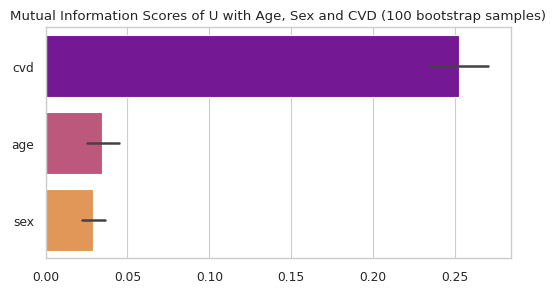

In [10]:
X = fair_heart_disease[['cvd','age','sex']]
y = fair_heart_disease['U']

N_MI = 100
mi_results = []

for i in range(N_MI):
  X_resampled, y_resampled = resample(X, y, n_samples=50, random_state=i,
                                      stratify=fair_heart_disease['ID'])
  mi_scores = mutual_info_regression(X_resampled, y_resampled, n_neighbors=5, random_state=4)
  mi_results.append(mi_scores)

mi_df = pd.DataFrame(mi_results, columns=X.columns)
mi_mean = mi_df.mean().sort_values(ascending=False)
mi_df = mi_df[mi_mean.index]

plt.figure(figsize=(6, 3))
ax = sns.barplot(data=mi_df, orient='h', palette='plasma')
plt.title('Mutual Information Scores of U with Age, Sex and CVD (100 bootstrap samples)')
plt.show()

#### Synthetic data alignment
We generate synthetic data from $U$ and compare it with the observed dataset. We explore where the feature distributions deviate from reality and could indicate a misspecification in the model's relationships.

##### Synthetic dataset

In [13]:
from scipy.stats import norm

np.random.seed(4)

def sample_categorical(probs_matrix):
  return [np.random.choice(len(probs), p=probs) for probs in probs_matrix]


def get_cat_probs(alpha, beta_U, beta_sex, beta_age, U, sex, age):
  logits = [a + b_U*U + b_sex*sex + b_age*age for a, b_U, b_sex, b_age
              in zip(alpha, beta_U, beta_sex, beta_age)]
  logits = np.transpose(np.array(logits))
  return np.exp(logits) / np.sum(np.exp(logits), axis=1, keepdims=True)

def get_binary_probs(alpha, beta_U, beta_sex, beta_age, U, sex, age):
  logit = alpha + beta_U*U + beta_sex*sex + beta_age*age
  return 1 / (1 + np.exp(-logit))

# SYNTHETIC DATASET reconstructed using inferred parameters and sampled U
synthetic_heart_disease = heart_disease[['age', 'sex', 'cvd']].copy()

# Compute the mean value of U for each individual in the dataset
mean_U = fair_heart_disease.groupby('ID')['U'].mean()
synthetic_heart_disease['U'] = synthetic_heart_disease.index.map(lambda x: mean_U[x])


#ECG
ecg_probs = get_cat_probs(alpha_ecg, beta_U_ecg, beta_sex_ecg, beta_age_ecg,
                          synthetic_heart_disease['U'],
                          synthetic_heart_disease['sex'],
                          synthetic_heart_disease['age'])
synthetic_heart_disease['synth_ecg'] = sample_categorical(ecg_probs)

#CP
cp_probs = get_cat_probs(alpha_cp, beta_U_cp, beta_sex_cp, beta_age_cp,
                          synthetic_heart_disease['U'],
                          synthetic_heart_disease['sex'],
                          synthetic_heart_disease['age'])
synthetic_heart_disease['synth_cp'] = sample_categorical(cp_probs)

#SLOPE
slope_probs = get_cat_probs(alpha_slope, beta_U_slope, beta_sex_slope, beta_age_slope,
                          synthetic_heart_disease['U'],
                          synthetic_heart_disease['sex'],
                          synthetic_heart_disease['age'])
synthetic_heart_disease['synth_slope'] = sample_categorical(slope_probs)

#ANG
ang_prob = get_binary_probs(alpha_ang, beta_U_ang, beta_sex_ang, beta_age_ang,
                          synthetic_heart_disease['U'],
                          synthetic_heart_disease['sex'],
                          synthetic_heart_disease['age'])
synthetic_heart_disease['synth_ang'] = np.random.binomial(1, ang_prob)

#FBS
fbs_prob = get_binary_probs(alpha_fbs, beta_U_fbs, beta_sex_fbs, beta_age_fbs,
                          synthetic_heart_disease['U'],
                          synthetic_heart_disease['sex'],
                          synthetic_heart_disease['age'])
synthetic_heart_disease['synth_fbs'] = np.random.binomial(1, fbs_prob)

#BP
mean_bp = alpha_bp + beta_U_bp*synthetic_heart_disease['U']\
              + beta_sex_bp*synthetic_heart_disease['sex']\
              + beta_age_bp*synthetic_heart_disease['age']
synthetic_heart_disease['synth_bp'] = np.random.normal(mean_bp, sigma_bp)


#CHOL
mean_chol = alpha_chol + beta_U_chol*synthetic_heart_disease['U']\
              + beta_sex_chol*synthetic_heart_disease['sex']\
              + beta_age_chol*synthetic_heart_disease['age']
synthetic_heart_disease['synth_chol'] = np.random.normal(mean_chol, sigma_chol)

#MHR
mean_mhr = alpha_mhr + beta_U_mhr*synthetic_heart_disease['U']\
              + beta_sex_mhr*synthetic_heart_disease['sex']\
              + beta_age_mhr*synthetic_heart_disease['age']
synthetic_heart_disease['synth_mhr'] = np.random.normal(mean_mhr, sigma_mhr)

#ST
zero_st_prob = get_binary_probs(alpha_zero_st, beta_U_zero_st, beta_sex_zero_st, beta_age_zero_st,
                          synthetic_heart_disease['U'],
                          synthetic_heart_disease['sex'],
                          synthetic_heart_disease['age'])
is_zero = np.random.rand(len(synthetic_heart_disease)) < zero_st_prob

mean_st = alpha_st + beta_U_st*synthetic_heart_disease['U']\
          + beta_sex_st*synthetic_heart_disease['sex']\
          + beta_age_st*synthetic_heart_disease['age']
non_zero_st = np.exp(np.random.normal(mean_st, sigma_st))

synthetic_heart_disease['synth_st'] = np.where(is_zero, 0, non_zero_st)

##### Feature distributions

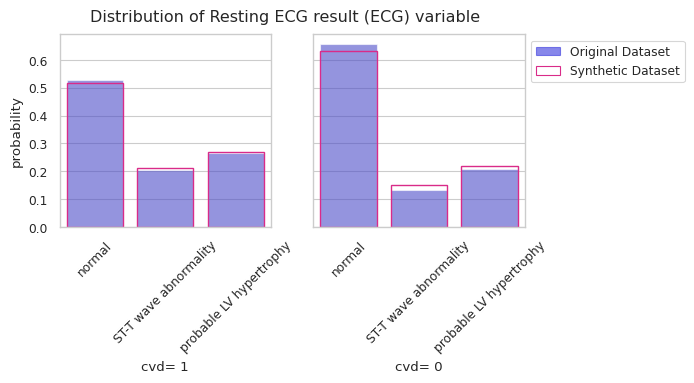

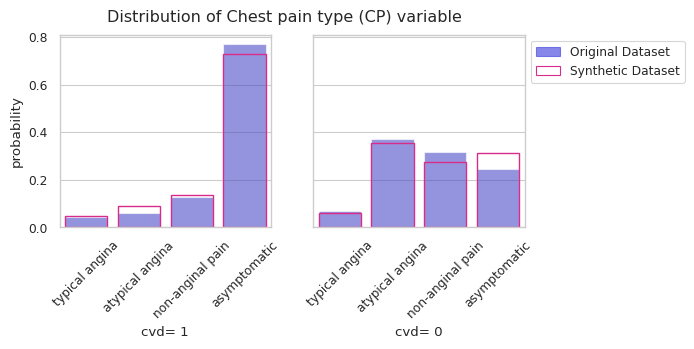

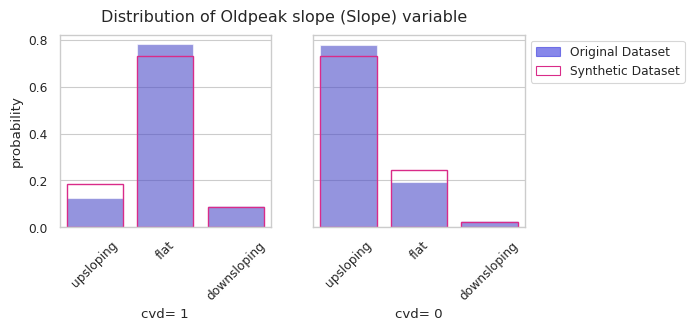

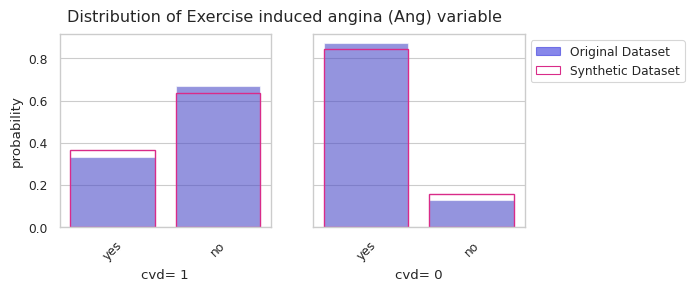

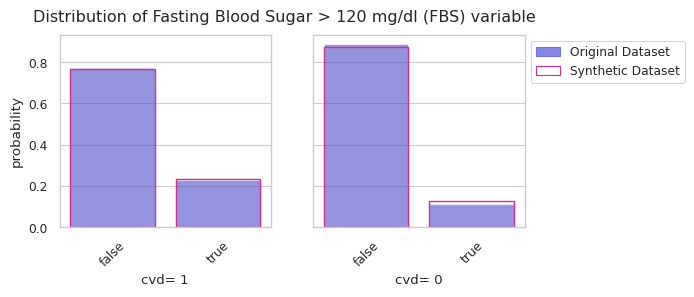

(<Figure size 600x250 with 2 Axes>,
 array([<Axes: xlabel='cvd= 1', ylabel='probability'>,
        <Axes: xlabel='cvd= 0', ylabel='probability'>], dtype=object))

In [20]:
synthetic_heart_disease.attrs = {'name':'Synthetic Dataset'}
heart_disease.attrs = {'name':'Original Dataset'}

# Alignment of categorical and binary features
plot_cat_dist_comparison(heart_disease, synthetic_heart_disease, 'cvd',
                         'ecg', 'synth_ecg', 'Resting ECG result (ECG)',
                         xticks=['normal','ST-T wave abnormality','probable LV hypertrophy'])
plot_cat_dist_comparison(heart_disease, synthetic_heart_disease, 'cvd',
                         'cp', 'synth_cp', 'Chest pain type (CP)',
                         xticks=['typical angina','atypical angina','non-anginal pain','asymptomatic'])
plot_cat_dist_comparison(heart_disease, synthetic_heart_disease, 'cvd',
                         'slope', 'synth_slope', 'Oldpeak slope (Slope)',
                         xticks=['upsloping','flat','downsloping'])
plot_cat_dist_comparison(heart_disease, synthetic_heart_disease, 'cvd',
                         'ang', 'synth_ang', 'Exercise induced angina (Ang)',
                         xticks=['yes', 'no'])
plot_cat_dist_comparison(heart_disease, synthetic_heart_disease, 'cvd',
                         'fbs', 'synth_fbs', 'Fasting Blood Sugar > 120 mg/dl (FBS)',
                         xticks=['false', 'true'])

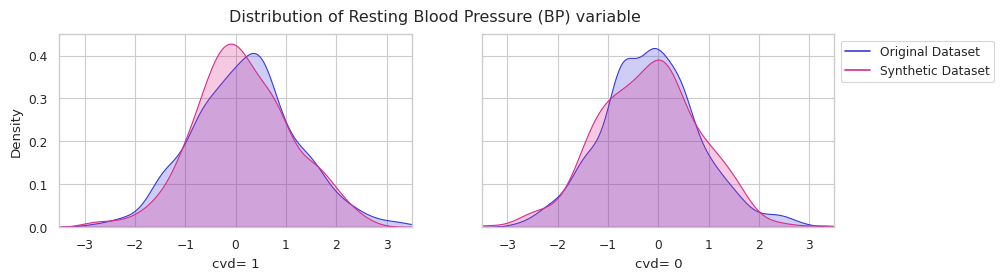

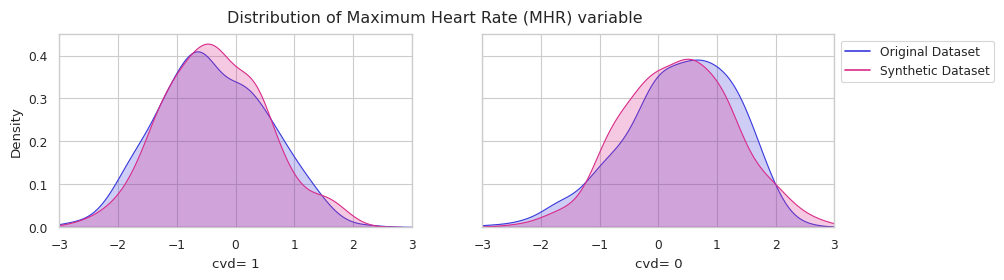

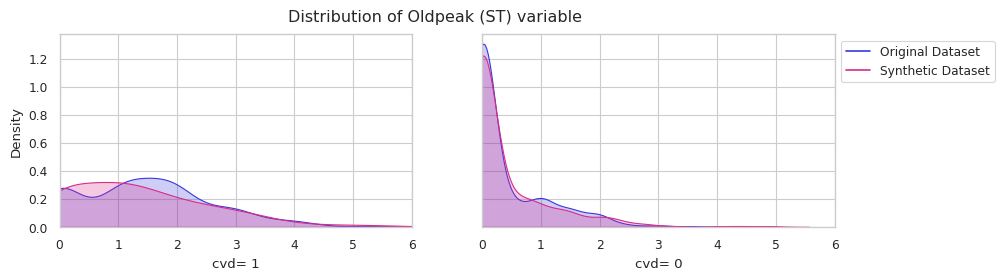

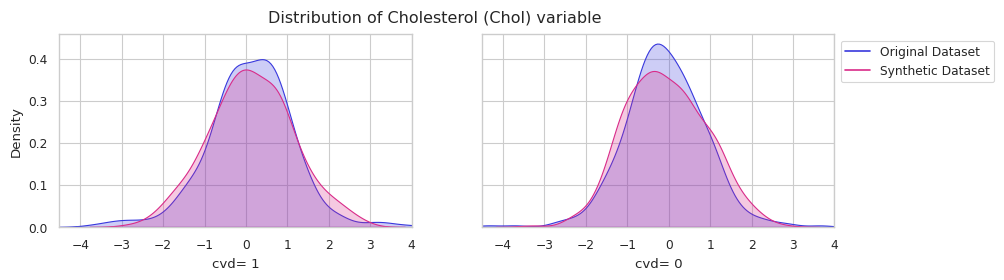

(<Figure size 1000x250 with 2 Axes>,
 array([<Axes: xlabel='cvd= 1', ylabel='Density'>,
        <Axes: xlabel='cvd= 0', ylabel='Density'>], dtype=object))

In [22]:
# Alignment of continuous features
plot_density_comparison(heart_disease, synthetic_heart_disease, 'cvd',
                        'bp', 'synth_bp', 'Resting Blood Pressure (BP)', -3.5,3.5)
plot_density_comparison(heart_disease, synthetic_heart_disease, 'cvd',
                        'mhr', 'synth_mhr', 'Maximum Heart Rate (MHR)', -3,3)
plot_density_comparison(heart_disease, synthetic_heart_disease, 'cvd',
                        'st', 'synth_st', 'Oldpeak (ST)', 0, 6)
plot_density_comparison(heart_disease, synthetic_heart_disease, 'cvd',
                        'chol', 'synth_chol', 'Cholesterol (Chol)', -4.5, 4)

#### Bias pathways
We analyse the parameters of the model to validate that the variables treated as sex-biased indeed have a strong causal link with the protected attribute.

## Counterfactual dataset

In [23]:
# COUNTERFACTUAL DATASET reconstructed using inferred parameters and sampled U
cf_heart_disease = heart_disease.copy()

# Compute the mean value of U for each individual in the dataset
mean_U = fair_heart_disease.groupby('ID')['U'].mean()
cf_heart_disease['U'] = cf_heart_disease.index.map(lambda x: mean_U[x])
cf_heart_disease['sex'] = 1 - cf_heart_disease['sex']

#ECG
ecg_probs = get_cat_probs(alpha_ecg, beta_U_ecg, beta_sex_ecg, beta_age_ecg,
                          cf_heart_disease['U'],
                          cf_heart_disease['sex'],
                          cf_heart_disease['age'])
cf_heart_disease['ecg'] = np.argmax(ecg_probs, axis=1)

#CP
cp_probs = get_cat_probs(alpha_cp, beta_U_cp, beta_sex_cp, beta_age_cp,
                          cf_heart_disease['U'],
                          cf_heart_disease['sex'],
                          cf_heart_disease['age'])
cf_heart_disease['cp'] = np.argmax(cp_probs, axis=1)

#SLOPE
slope_probs = get_cat_probs(alpha_slope, beta_U_slope, beta_sex_slope, beta_age_slope,
                          cf_heart_disease['U'],
                          cf_heart_disease['sex'],
                          cf_heart_disease['age'])
cf_heart_disease['slope'] = np.argmax(slope_probs, axis=1)

#ANG
ang_prob = get_binary_probs(alpha_ang, beta_U_ang, beta_sex_ang, beta_age_ang,
                          cf_heart_disease['U'],
                          cf_heart_disease['sex'],
                          cf_heart_disease['age'])
cf_heart_disease['ang'] = (ang_prob > 0.5).astype(int)

#FBS
fbs_prob = get_binary_probs(alpha_fbs, beta_U_fbs, beta_sex_fbs, beta_age_fbs,
                          cf_heart_disease['U'],
                          cf_heart_disease['sex'],
                          cf_heart_disease['age'])
cf_heart_disease['fbs'] = (fbs_prob > 0.5).astype(int)

#BP
cf_heart_disease['bp'] = alpha_bp + beta_U_bp*cf_heart_disease['U']\
              + beta_sex_bp*cf_heart_disease['sex']\
              + beta_age_bp*cf_heart_disease['age']


#CHOL
cf_heart_disease['chol'] = alpha_chol + beta_U_chol*cf_heart_disease['U']\
              + beta_sex_chol*cf_heart_disease['sex']\
              + beta_age_chol*cf_heart_disease['age']

#MHR
cf_heart_disease['mhr'] = alpha_mhr + beta_U_mhr*cf_heart_disease['U']\
              + beta_sex_mhr*cf_heart_disease['sex']\
              + beta_age_mhr*cf_heart_disease['age']

#ST
zero_st_prob = get_binary_probs(alpha_zero_st, beta_U_zero_st, beta_sex_zero_st, beta_age_zero_st,
                          cf_heart_disease['U'],
                          cf_heart_disease['sex'],
                          cf_heart_disease['age'])

mean_st = alpha_st + beta_U_st*cf_heart_disease['U']\
          + beta_sex_st*cf_heart_disease['sex']\
          + beta_age_st*cf_heart_disease['age']
non_zero_st = np.exp(mean_st + (sigma_st**2/2))

cf_heart_disease['st'] = (1 - zero_st_prob)*non_zero_st


In [ ]:
cf_heart_disease.to_csv(f'{PROJECT_ROOT}/data/cf_heart_disease_hybrid.csv', index=False)
print('Counterfactual dataset saved')

Counterfactual dataset saved
